<a href="https://www.kaggle.com/code/hmcjpg/network-ids-94-0?scriptVersionId=188853685" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/UNSW_NB15_testing-set.csv
/kaggle/input/UNSW-NB15_1.csv
/kaggle/input/UNSW_NB15_training-set.csv
/kaggle/input/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/UNSW-NB15_4.csv
/kaggle/input/UNSW-NB15_3.csv
/kaggle/input/UNSW-NB15_2.csv
/kaggle/input/NUSW-NB15_features.csv


# Introduction to Intrusion Detection Systems (IDS)

## What is an Intrusion Detection System?

An Intrusion Detection System (IDS) is a security tool designed to monitor networks/systems for malicious or otherwise abnormal activity. It can identify and alert administrators about potential threats, helping to protect sensitive data and maintain network integrity.

## What are we building in this notebook?

###  Today we'll be using this dataset to adapt a ML infrastructure for a Network-based IDS (NIDS)
Potential application and usage:
- **Real-time Monitoring**: Continuously scans for unusual activities, ensuring prompt response to incidents.
- **Autonomous Alerting**: Quickly identifies potential threats and alerts administrators, without the need of constant human monitering
- **Security Compliance**: Helps organizations meet regulatory requirements by maintaining a secure network environment.

## Why is this relevant?

Intrusion Detection Systems are essential to any SOC analyst or security team for maintaining their organization's network security. By monitoring and analyzing activities, IDS provides critical early warnings of potential threats, helping to prevent breaches and protect organizational assets. By utilizing AI as a component, we are able to assist security teams by using models trained on prior network traffic logs to ensure accuracy and aid personnel.


# Initializing Dataset
In this section, we provide our necessary imports and define file-path destinations.

## Imports
I generally split imports up by the source module they originate from. Note, this may still contain unused imports from writing and testing this code. These would be removed for production code, but I choose to keep them on the basis of me using this analysis for studying other datasets.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, accuracy_score, precision_score
from sklearn.feature_selection import SelectKBest, chi2

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Reshape
from keras.optimizers import SGD, Adam

import graphviz
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from fastai.callback.all import *
from fastai.tabular.all import *
from fastai.metrics import accuracy, Precision, Recall, RocAuc
from skimage.io import imread
from ipywidgets import interact
import plotly.graph_objects as go

# Dice Coefficient functions
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    return (2. * K.dot(y_true_f, K.transpose(y_pred_f)) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

2024-07-18 16:59:01.102405: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 16:59:01.102569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 16:59:01.281910: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## File Pathing
Here, we're reading in our dataframes. Note, the dataset already provides a distinct testing set; we'll keep this isolated from the rest of the training data.

In [3]:
np.set_printoptions(linewidth=130)
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    path = Path('/kaggle/input/')
else:
    import zipfile, kaggle
    path = Path('unsw-nb15')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'UNSW_NB15_training-set.csv')
tst_df = pd.read_csv(path/'UNSW_NB15_testing-set.csv')
modes = df.mode().iloc[0]

## Define Dataframes
Here, I did light pre-processing, which entailed the following:\
1 - Filled in any NA's\
2 - Used encoding to index notable variables

Note, we are looking to detect malicious traffic as our intended target. This is following the strategy of many other notebooks, which aimed at predicting the 'label' category, a column from the dataset that simply denotes whether a snippet of traffic was normal or not. Further testing may provide more detailed analyses on predicting the specific labels themselves.

In [4]:
def proc_data(df, modes):
    df.fillna(modes, inplace=True)
    df['Proto'] = pd.Categorical(df['proto']).codes
    df['service'] = pd.Categorical(df['service']).codes
    df['state'] = pd.Categorical(df['state']).codes

proc_data(df, modes)
proc_data(tst_df, modes)

cats = ["Proto", "service", "state"]
conts = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss']
dep = "label" # Here's one of the fields to modify should we try to predict traffic as opposed to label

# Cleaning our Data

When I initially tried working with this dataset, I only provided the above section in regards to pre-processing. This did not lead to good target readings; I hypothesize this was due to improper data cleanings, such that high degreees of cardinality skewed results of the categorical columns. Additionally, I failed to account for outliers. As such, I instead adapted the cleaning procedure put in place by Carl Kirstein in his 97.7% accuracy model. The code for the cleaning section is all adapted from his notebook, which I would definitely recommend exploring. However, my surrounding commentary is rather my own understood rationale behind why it works, which may not be perfectly accurate to Carl's original intent.

## Dropped Data
Here, I will drop the attack category, as it's merely an extension of our target label (which is malicious vs. non-malicious traffic data), and it would make classification otherwise trivial. Additionally, ID introduces a large number of otherwise unhelpful cardinality.

In [5]:
list_drop = ['id','attack_cat']
df.drop(list_drop,axis=1,inplace=True)

## Clamping
Here, we'll prune our values to only contain data from within the 95% percentile.

In [6]:
# Clamp extreme Values
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all')


DEBUG =0

for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('max = '+str(df_numeric[feature].max()))
        print('75th = '+str(df_numeric[feature].quantile(0.95)))
        print('median = '+str(df_numeric[feature].median()))
        print(df_numeric[feature].max()>10*df_numeric[feature].median())
        print('----------------------------------------------------')
    if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
        df[feature] = np.where(df[feature]<df[feature].quantile(0.95), df[feature], df[feature].quantile(0.95))
        
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.describe(include='all')

,dur,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,Proto
count,82332.000000,82332.000000,82332.000000,82332.00000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,0.445016,1.301924,3.374751,11.84186,9.178424,1580.566135,2866.918367,71576.702810,180.967667,95.713003,...,3.388901,7.160679,0.008284,0.008381,0.092066,5.974809,8.832532,0.011126,0.550600,109.348273
std,0.672222,1.753661,0.670372,15.66461,14.504212,2948.850472,7525.606738,102631.946851,101.513358,116.667722,...,5.029129,10.481621,0.091171,0.092485,0.289121,6.867156,10.124902,0.104891,0.497436,18.637282
min,0.000000,0.000000,0.000000,1.00000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000008,0.000000,3.000000,2.00000,0.000000,114.000000,0.000000,28.606114,62.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,111.000000
50%,0.014138,0.000000,3.000000,6.00000,2.000000,534.000000,178.000000,2650.176667,254.000000,29.000000,...,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000,111.000000
75%,0.719360,2.000000,4.000000,12.00000,10.000000,1280.000000,956.000000,111111.107200,254.000000,252.000000,...,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000,117.000000
max,2.403792,5.000000,6.000000,60.00000,54.000000,12472.000000,30622.000000,333333.321500,255.000000,253.000000,...,18.000000,37.000000,2.000000,2.000000,1.000000,25.000000,36.000000,1.000000,1.000000,130.000000


## Log Function
Next, we'll be applying a log function to normalize the data; to be more precise, we are applying it on the integer-base features so we can treat them to be more categorical.

In [7]:
df_numeric = df.select_dtypes(include=[np.number])
df_before = df_numeric.copy()
DEBUG = 0
for feature in df_numeric.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_numeric[feature].nunique()))
        print(df_numeric[feature].nunique()>50)
        print('----------------------------------------------------')
    if df_numeric[feature].nunique()>50:
        if df_numeric[feature].min()==0:
            df[feature] = np.log(df[feature]+1)
        else:
            df[feature] = np.log(df[feature])

df_numeric = df.select_dtypes(include=[np.number])

## Reduce Labels
There's a large amount of cardinality evident within the labels -- some of the categorical data variables have many types (ex. many protocols utilized within network traffic), and we aim to reduce this. We'll only look at the most frequently appearing labels, and mark the remainder as relatively unused.

In [8]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

DEBUG = 0
for feature in df_cat.columns:
    if DEBUG == 1:
        print(feature)
        print('nunique = '+str(df_cat[feature].nunique()))
        print(df_cat[feature].nunique()>6)
        print(sum(df[feature].isin(df[feature].value_counts().head().index)))
        print('----------------------------------------------------')
    
    if df_cat[feature].nunique()>6:
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')
        
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto
count,82332
unique,6
top,tcp
freq,43095


## Feature Selection Graph
Helpful for us to visualize the most prominent features as we test which ones lead to the most accurate model. This is the last snippet of code pulled from Carl's notebook; note, this was slightly modified so I could process categorical values. This section is somewhat redundant in my codeset; initially, when I made by GBM I used this to help with selecting parameters, but I found strong performance (~94%) without specifying targets. This is an option for further improving this notebook.

In [9]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2, k='all')

X = df.iloc[:, 4:-2]

# Ensure the target variable is categorical
y = df.iloc[:, -1]
if y.dtype != 'int':
    y = pd.Categorical(y).codes

fit = best_features.fit(X, y)

df_scores = pd.DataFrame(fit.scores_)
df_col = pd.DataFrame(X.columns)

feature_score = pd.concat([df_col, df_scores], axis=1)
feature_score.columns = ['feature', 'score']
feature_score.sort_values(by=['score'], ascending=True, inplace=True)

fig = go.Figure(go.Bar(
    x=feature_score['score'][0:21],
    y=feature_score['feature'][0:21],
    orientation='h'
))

fig.update_layout(
    title="Top 20 Features",
    height=1200,
    showlegend=False,
)

fig.show()

## Post-processing
Here, we'll set our seed, split our non-test data into training/validation sets, extract and isolate features and target variables, and finally standardize our dataframes.

In [10]:
random.seed(42) # The answer to life, the universe and everything.
trn_df, val_df = train_test_split(df, test_size=0.25)

def xs_y(df):
    xs = df[cats + conts].copy()
    return xs, df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)
tst_xs, tst_y = xs_y(tst_df)

scaler = StandardScaler()
trn_xs[conts] = scaler.fit_transform(trn_xs[conts])
val_xs[conts] = scaler.transform(val_xs[conts])
tst_xs[conts] = scaler.transform(tst_xs[conts])

# Creating our Models
Here, we'll be creating a simple naive model and a decision tree to test our more complex models against. Our final result will be to create an ensemble between a Random Forest, Gradient Boosting Classifier, and a Neural Network, testing our performance along the way.

## Benchmark Model
Here, we'll first evaluate a simple baseline model to serve as our benchmark against more complex models. Due to the encoding, our precision will just return values of 1.0, so that metric is not included here.

In [11]:
# Simple model based on the 'Proto' feature being set to 0.

val_y_enc = LabelEncoder().fit_transform(val_y)
preds = val_xs['Proto'] == 0
preds_enc = preds.astype(int)
print("Benchmark Mean Absolute Error (MAE)",mean_absolute_error(val_y_enc, preds_enc))
print("Benchmark Accuracy:", accuracy_score(val_y_enc, preds_enc))

Benchmark Mean Absolute Error (MAE) 0.5443812855268911
Benchmark Accuracy: 0.45561871447310887


## Decision Tree Model
Before we make our Random Forest, we'll see if we can signficantly improve our performance with merely a decision tree.

In [12]:
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                        special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, trn_xs, size=10)
print("Decision Tree MAE", mean_absolute_error(val_y, m.predict(val_xs)))
print("Decision Tree Accuracy:", accuracy_score(val_y, m.predict(val_xs)))
print("Decision Tree Precision:", precision_score(val_y, m.predict(val_xs)))

Decision Tree MAE 0.1612495748919011
Decision Tree Accuracy: 0.8387504251080989
Decision Tree Precision: 0.9047081751974562


## Random Forest Model
Note: Check comments for hyperparameter values to modify.

In [13]:
rf = RandomForestClassifier(
    n_estimators=200,         # Number of trees
    max_depth=20,             # OVERFIT Depth of forest, important to scale properly to avoid overfitting
    min_samples_split=12,     # OVERFIT Samples split count
    min_samples_leaf=6,       # OVERFIT Leaf count
    max_features='sqrt',      # At each split, we're considering to use the square root of the feature count.
    random_state=42
)
rf.fit(trn_xs, trn_y)
print("Random Forest MAE:",mean_absolute_error(val_y, rf.predict(val_xs)))
print("Random Forest Accuracy:", accuracy_score(val_y, rf.predict(val_xs)))
print("Random Forest Precision:", precision_score(val_y, rf.predict(val_xs)))

Random Forest MAE: 0.06277024729145411
Random Forest Accuracy: 0.9372297527085459
Random Forest Precision: 0.9683604080090669


## Gradient Boosting Model
Note: Check comments for hyperparameter values to modify.

In [14]:
# To reference the earlier portion of the notebook, comment/uncomment here to test out using only
# specific features on the GBM model.

"""
important_features = ['sbytes', 'dbytes', 'service', 'rate']
#trn_xs_reduced = trn_xs[important_features]
#val_xs_reduced = val_xs[important_features]
#tst_xs_reduced = tst_xs[important_features]
"""
gbm = GradientBoostingClassifier(
    n_estimators=300,        # Increase the number of boosting stages
    learning_rate=0.05,      # Lower learning rate for better performance
    max_depth=5,             # Increase depth for higher complexity
    min_samples_split=10,    # Increase to prevent overfitting
    min_samples_leaf=4,      # Increase to prevent overfitting
    subsample=0.8,           # Percentage of samples used for each base learner
    random_state=42
)
gbm.fit(trn_xs, trn_y)
print("GBM MAE:", mean_absolute_error(val_y, gbm.predict(val_xs)))
print("GBM Accuracy:", accuracy_score(val_y, gbm.predict(val_xs)))
print("GBM Precision:", precision_score(val_y, gbm.predict(val_xs)))

GBM MAE: 0.06364475538065394
GBM Accuracy: 0.936355244619346
GBM Precision: 0.9661894895460539


## Summary and Ensembling
This section provides a succinct line-by-line comparison of models before ensembling them. This was useful for looking at all my models together, check which ones were impacting performance and knowing where to go back and adjust hyperparameters.

In [15]:
def train(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return mean_absolute_error(y_val, preds), accuracy_score(y_val, preds), precision_score(y_val, preds)
    
# Example with RandomForest
rf_mae = train(rf, trn_xs, trn_y, val_xs, val_y)
print(f"Random Forest Statistics (MAE, Accuracy, Precision):\n {rf_mae}")

# Example with GradientBoosting
gbm_mae = train(gbm, trn_xs, trn_y, val_xs, val_y)
print(f"Gradient Boosting Statistics (MAE, Accuracy, Precision):\n {gbm_mae}")


Random Forest Statistics (MAE, Accuracy, Precision):
 (0.06277024729145411, 0.9372297527085459, 0.9683604080090669)
Gradient Boosting Statistics (MAE, Accuracy, Precision):
 (0.06364475538065394, 0.936355244619346, 0.9661894895460539)


## Ensemble Final Statistics

In [16]:

rf_preds_val = rf.predict(val_xs)
gbm_preds_val = gbm.predict(val_xs)

ensemble_preds_val = (rf_preds_val + gbm_preds_val) / 2
ensemble_preds_val = np.round(ensemble_preds_val)

ensemble_mae = mean_absolute_error(val_y, ensemble_preds_val)
ensemble_accuracy = accuracy_score(val_y, ensemble_preds_val)
ensemble_precision = precision_score(val_y, ensemble_preds_val)

print("Ensemble MAE:", ensemble_mae)
print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble Precision:", ensemble_precision)

Ensemble MAE: 0.06393625807705387
Ensemble Accuracy: 0.9360637419229462
Ensemble Precision: 0.9751248559354591


# Final Metrics
Finally, we provide a classification report with a multitude of varying metrics, including precision, recall, f1 score, and accuracy. Additionally, we provide a confusion matrix across our notable models to assist in visualizing and evaluating error.

Accuracy: 0.8387504251080989
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      9373
           1       0.90      0.79      0.84     11210

    accuracy                           0.84     20583
   macro avg       0.84      0.84      0.84     20583
weighted avg       0.85      0.84      0.84     20583



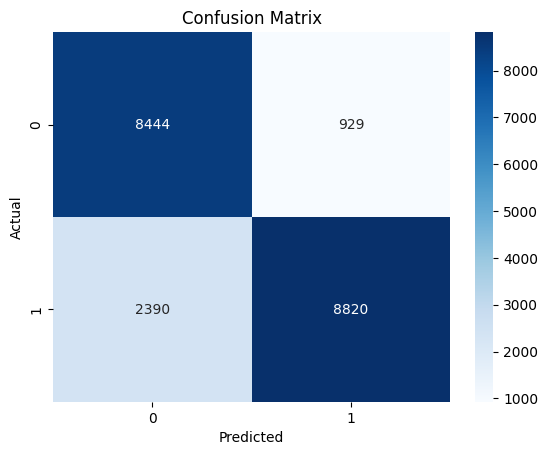

Accuracy: 0.9372297527085459
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9373
           1       0.97      0.91      0.94     11210

    accuracy                           0.94     20583
   macro avg       0.94      0.94      0.94     20583
weighted avg       0.94      0.94      0.94     20583



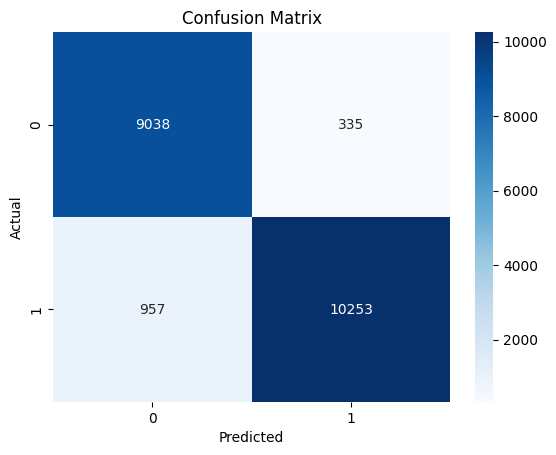

Accuracy: 0.936355244619346
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9373
           1       0.97      0.92      0.94     11210

    accuracy                           0.94     20583
   macro avg       0.94      0.94      0.94     20583
weighted avg       0.94      0.94      0.94     20583



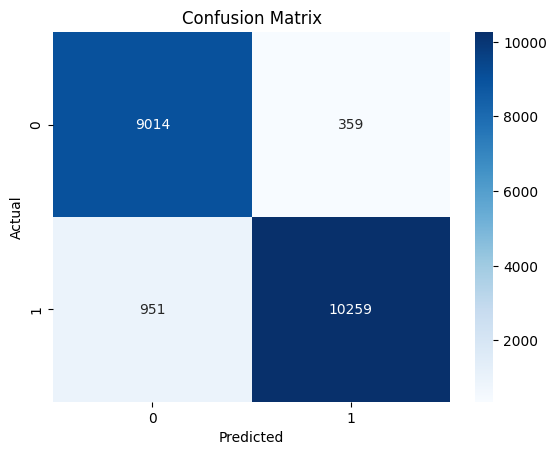

In [17]:
# Train and evaluate models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



def train_evaluate_model(model, trn_xs, trn_y, val_xs, val_y):
    model.fit(trn_xs, trn_y)
    preds = model.predict(val_xs)
    print(f"Accuracy: {accuracy_score(val_y, preds)}")
    print(f"Classification Report:\n{classification_report(val_y, preds)}")
    cm = confusion_matrix(val_y, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Decision Tree Classifier
train_evaluate_model(m, trn_xs, trn_y, val_xs, val_y)

# Random Forest Classifier
train_evaluate_model(rf, trn_xs, trn_y, val_xs, val_y)

# Gradient Boosting Classifier
train_evaluate_model(gbm, trn_xs, trn_y, val_xs, val_y)
